In [20]:
from cffi import FFI
import time
import numpy as np
import matplotlib.pyplot as plt
from numba import jit

In [32]:
import peak_mark_cffi._peak_find as _test

In [33]:
filename = 'mic_data/Fulldata_initiator_19delay.dat'
data = np.loadtxt(filename, delimiter=',').flatten()

In [34]:
# Sliding Goertzel
@jit
def sg_v2(x, k=25*4):
    Pxx = []
    N = 64*4
    w = 2*np.pi*k/N;
    cw = np.cos(w);
    c = 2*cw;
    sw = np.sin(w);
    z1=0;
    z2=0;
    #while (idx < (len(x)-1)):
    for idx in range(len(x)):
        if idx<N:
            z0 = x[idx] + c*z1 - z2;
        else:
            z0 = x[idx] - x[idx-N] + c*z1 -z2;
        z2 = z1;
        z1 = z0;

        P = z2*z2 + z1*z1 - c * z1*z2
        Pxx.append(P)
    return np.array(Pxx)

In [35]:
y = sg_v2(data, k=100)

In [45]:
settings = _test.ffi.new("settings_t *")
history = _test.ffi.new("history_t *")

settings.lag = 256
settings.threshold = 5
settings.influence = 1e-4
settings.width = 100
history.start = -1
history.pkidx = -1
history.length = 0
history.pk = -1
history.avg = 0
history.std2 = 0
history.time_since_pk = -1
history.time_pk = -1
history.init = 0

x = y.astype(np.double)
x_p = _test.ffi.cast('double *', x.ctypes.data)
N = len(x)
signals = np.zeros(len(y));
signals_p = _test.ffi.cast('double *', signals.ctypes.data)
filteredY = np.zeros(settings.lag);
filteredY_p = _test.ffi.cast('double *', filteredY.ctypes.data)
debug = np.zeros(len(y));
debug_p = _test.ffi.cast('double *', debug.ctypes.data)

In [47]:
results = _test.lib.peakMark(x_p, N, settings, history, filteredY_p, signals_p, debug_p)

In [48]:
last = results
r = []
while True:
    if last == _test.ffi.NULL:
        break
    r.append([last.start, last.length, last.pk_idx, last.pk_time, last.pk])
    last = last.next
print(np.array(r, dtype=int))
print(results, last)

[[        1371          510         1663         1663 152403087472]
 [        3262          443         3868         2205    478121413]
 [        5308          510         5601         1733 152990931635]
 [        7577          444         7830         2229    501183231]
 [        9263          508         9553         1723 153182052006]
 [       11545          443        11800         2247    500638677]
 [       13231          505        13521         1721 153410743501]
 [       15512          441        15769         2248    492011011]
 [       17200          511        17493         1724 153276197562]
 [       19483          442        19738         2245    490197741]
 [       21167          508        21456         1718 153548487660]
 [       23455          442        23710         2254    488724265]
 [       25134          509        25424         1714 153715238746]
 [       27414          443        27673         2249    489837803]
 [       29102          509        29392        

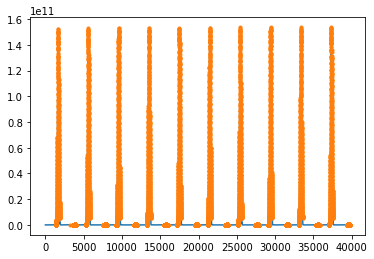

In [51]:
t = np.arange(len(x))
plt.plot(t, x)
plt.plot(t[signals==1], x[signals==1],'.')

In [ ]:
_test.lib.free_results(results)

In [ ]:
settings = _test.ffi.new("settings_t *")
history = _test.ffi.new("history_t *")

settings.lag = 256
settings.threshold = 5
settings.influence = 1e-4
history.start = -1
history.pkidx = -1
history.length = 0
history.pk = -1
history.avg = 0
history.std2 = 0
history.time_since_pk = -1
history.time_pk = -1
history.init = 0

x = y.astype(np.double)
x_p = _test.ffi.cast('double *', x.ctypes.data)
N = len(x)
signals = np.zeros(len(y));
signals_p = _test.ffi.cast('double *', signals.ctypes.data)
filteredY = np.zeros(settings.lag);
filteredY_p = _test.ffi.cast('double *', filteredY.ctypes.data)
debug = np.zeros(len(y));
debug_p = _test.ffi.cast('double *', debug.ctypes.data)

In [7]:
for count in range(8):
    last = _test.lib.peakMark(x_p + count*64, 64, settings, history, filteredY_p, signals_p, debug_p)
    print(count, history.time_since_pk, history.start, history.length, history.time_pk, history.init)
    if (last != _test.ffi.NULL):
        print(count, [last.start, last.length, last.pk_idx, last.pk_time, last.pk])
        _test.lib.free_results(last)

0 63 -1 0 -1 64
1 127 -1 0 -1 128
2 191 -1 0 -1 192
3 255 -1 0 -1 256
4 319 -1 0 -1 256
5 15 51 13 8 256
5 [41, 1, 41, 361, 530.7800174518406]
6 79 51 77 44 256
7 143 51 141 44 256


In [ ]:
history.time_since_pk, history.start, history.length, history.pkidx

In [ ]:
last = results
rr = []
while True:
    if last == _test.ffi.NULL:
        break
    rr.append([last.start, last.length, last.pk_idx, last.pk_time, last.pk])
    last = last.next
print(np.array(rr, dtype=int))
print(results, last)

In [ ]:
np.array(r)[:,0] - np.array(rr)[:-1,0]

In [16]:
d_std = []
d_crit = []
def peak_marking(y, lag, threshold, influence):
    global debug
    pks = []
    start = -1
    pk = 0
    pk_idx = -1
    length = 0
    signals = np.zeros(len(y), dtype=bool)
    filteredY = np.array(y[:lag])
    avgFilter = np.mean(filteredY)
    stdFilter = np.std(filteredY)
    for i in range(lag, len(y)):
        d_crit.append(abs(y[i]-avgFilter))
        if abs(y[i] - avgFilter) > threshold * stdFilter:
            if y[i]>avgFilter:
                if start<0:
                    start = i
                    length = 1
                else:
                    length += 1
                signals[i] = True
                if y[i] > pk:
                    pk, pk_idx = y[i], i
                filteredY[i%lag] = influence * y[i] + (1 - influence) * filteredY[(i-1)%lag]
        else:
            signals[i] = False
            filteredY[i%lag] = y[i]
            if start > 0:
                pks.append([start, length, pk_idx, pk])
                start, pk_idx, pk, length = -1, -1, 0, 0
        if (start>0):
            print(i, start, length, pk_idx)
        avgFilter = np.mean(filteredY)
        stdFilter = np.std(filteredY)
        d_std.append(stdFilter)
    print(avgFilter, stdFilter)
    #print(filteredY)
    return signals, pks

In [17]:
s,pks = peak_marking(x[:64], 256, 5, 1e-4)

1260.966788167958 896.0114603575524


In [19]:
39744//64

621